# Extracellular Electrophysiology Data

At the Allen Institute for Brain Science we carry out in vivo extracellular electrophysiology (ecephys) experiments  in awake animals using high-density Neuropixels probes. The data from these experiments are organized into *sessions*, where each session is a distinct continuous recording period. During a session we collect:

- spike times and characteristics (such as mean waveforms) from up to 6 neuropixels probes
- local field potentials
- behavioral data, such as running speed and eye position
- visual stimuli which were presented during the session
- cell-type specific optogenetic stimuli that were applied during the session

The AllenSDK contains code for accessing across-session (project-level) metadata as well as code for accessing detailed within-session data. The standard workflow is to use project-level tools, such as `EcephysProjectCache` to identify and access sessions of interest, then delve into those sessions' data using `EcephysSession`.


Project-level
------------------
The `EcephysProjectCache` class in `allensdk.brain_observatory.ecephys.ecephys_project_cache` accesses and stores data pertaining to many sessions. You can use this class to run queries that span all collected sessions and to download data for individual sessions.
* <a href='#Obtaining-an-EcephysProjectCache'>Obtaining an `EcephysProjectCache`</a>
* <a href='#Querying-across-sessions'>Querying sessions</a>
* <a href='#Querying-across-probes'>Querying probes</a>
* <a href='#Querying-across-units'>Querying units</a>
* <a href='#Surveying-metadata'>Surveying metadata</a>


Session-level
-------------------
The `EcephysSession` class in `allensdk.brain_observatory.ecephys.ecephys_session` provides an interface to all of the data for a single session, aligned to a common clock. This notebook will show you how to use the `EcephysSession` class to extract these data.
* <a href='#Obtaining-an-EcephysSession'>Obtaining an `EcephysSession`</a>
* <a href='#Stimulus-presentations'>Stimulus information</a>
* <a href='#Spike-data'>Spike data</a>
* <a href='#Spike-histograms'>Spike histograms</a>
* <a href='#Running-speed'>Running speed</a>
* <a href='#Optogenetic-stimulation'>Optogenetic stimulation</a>
* <a href='#Local-field-potential'>Local Field Potential</a>
* <a href='#Current-source-density'>Current source density</a>
* <a href='#Waveforms'>Unitwise mean waveforms</a>
* <a href='#Suggested-exercises'>Suggested exercises</a>
* <a href='#Eye-tracking-ellipse-fits-and-estimated-screen-gaze-location'>Eye tracking ellipse fits and estimated screen gaze location</a>

In [20]:
# first we need a bit of import boilerplate
import os

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import (
    EcephysSession, 
    removed_unused_stimulus_presentation_columns
)
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

### Obtaining an `EcephysProjectCache`

In order to create an `EcephysProjectCache` object, you need to specify two things:
1. A remote source for the object to fetch data from. We will instantiate our cache using `EcephysProjectCache.from_warehouse()` to point the cache at the Allen Institute's public web API.
2. A path to a manifest json, which designates filesystem locations for downloaded data. The cache will try to read data from these locations before going to download those data from its remote source, preventing repeated downloads.

In [21]:
# Example cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join("E:\local\ecephys_cache_dir", "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

### Querying across sessions

Using your `EcephysProjectCache`, you can download a table listing metadata for all sessions.

In [22]:
cache.get_session_table().head()

published_at  specimen_id           session_type  \
id                                                                    
715093703  2019-10-03T00:00:00Z    699733581  brain_observatory_1.1   
719161530  2019-10-03T00:00:00Z    703279284  brain_observatory_1.1   
721123822  2019-10-03T00:00:00Z    707296982  brain_observatory_1.1   
732592105  2019-10-03T00:00:00Z    717038288  brain_observatory_1.1   
737581020  2019-10-03T00:00:00Z    718643567  brain_observatory_1.1   

           age_in_days sex                                    full_genotype  \
id                                                                            
715093703        118.0   M    Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
719161530        122.0   M    Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
721123822        125.0   M  Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
732592105        100.0   M                                            wt/wt   
737581020        108.0   M                                            wt/wt   

           unit_count  channel_count  probe_count  \
id                                                  
715093703         884           2219            6   
719161530         755           2214            6   
721123822         444           2229            6   
732592105         824           1847            5   
737581020         568           2218            6   

                                  ecephys_structure_acronyms  
id                                                            
715093703  [CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ...  
719161530  [TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N...  
721123822  [MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ...  
732592105       [grey, VISpm, nan, VISp, VISl, VISal, VISrl]  
737581020      [grey, VISmma, nan, VISpm, VISp, VISl, VISrl]

### Querying across probes

... or for all probes

In [23]:
cache.get_probes().head()

ecephys_session_id  lfp_sampling_rate    name phase  sampling_rate  \
id                                                                              
729445648           719161530        1249.998642  probeA    3a   29999.967418   
729445650           719161530        1249.996620  probeB    3a   29999.918880   
729445652           719161530        1249.999897  probeC    3a   29999.997521   
729445654           719161530        1249.996707  probeD    3a   29999.920963   
729445656           719161530        1249.999979  probeE    3a   29999.999500   

           has_lfp_data  unit_count  channel_count  \
id                                                   
729445648          True          87            374   
729445650          True         202            368   
729445652          True         207            373   
729445654          True          93            358   
729445656          True         138            370   

                                 ecephys_structure_acronyms  
id                                                           
729445648                [APN, LP, MB, DG, CA1, VISam, nan]  
729445650      [TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan]  
729445652                [APN, NOT, MB, DG, SUB, VISp, nan]  
729445654              [grey, VL, CA3, CA2, CA1, VISl, nan]  
729445656  [PO, VPM, TH, LP, LGd, CA3, DG, CA1, VISal, nan]

### Querying across channels

... or across channels.

In [24]:
cache.get_channels().head()

ecephys_probe_id  local_index  probe_horizontal_position  \
id                                                                    
849705558         792645504            1                         11   
849705560         792645504            2                         59   
849705562         792645504            3                         27   
849705564         792645504            4                         43   
849705566         792645504            5                         11   

           probe_vertical_position  anterior_posterior_ccf_coordinate  \
id                                                                      
849705558                       20                             8165.0   
849705560                       40                             8162.0   
849705562                       40                             8160.0   
849705564                       60                             8157.0   
849705566                       60                             8155.0   

           dorsal_ventral_ccf_coordinate  left_right_ccf_coordinate  \
id                                                                    
849705558                         3314.0                     6862.0   
849705560                         3307.0                     6866.0   
849705562                         3301.0                     6871.0   
849705564                         3295.0                     6875.0   
849705566                         3288.0                     6879.0   

           ecephys_structure_id ecephys_structure_acronym  ecephys_session_id  \
id                                                                              
849705558                 215.0                       APN           779839471   
849705560                 215.0                       APN           779839471   
849705562                 215.0                       APN           779839471   
849705564                 215.0                       APN           779839471   
849705566                 215.0                       APN           779839471   

           lfp_sampling_rate phase  sampling_rate  has_lfp_data  unit_count  
id                                                                           
849705558        1250.001479    3a   30000.035489          True           0  
849705560        1250.001479    3a   30000.035489          True           0  
849705562        1250.001479    3a   30000.035489          True           0  
849705564        1250.001479    3a   30000.035489          True           0  
849705566        1250.001479    3a   30000.035489          True           0

In [25]:
print(cache.get_channels().shape[0])

123224


### Querying across units

... as well as for sorted units.

In [26]:
units = cache.get_units()
units.head()

waveform_PT_ratio  waveform_amplitude  amplitude_cutoff  \
id                                                                   
915956282           0.611816          164.878740          0.072728   
915956340           0.439372          247.254345          0.000881   
915956345           0.500520          251.275830          0.001703   
915956349           0.424620          177.115380          0.096378   
915956356           0.512847          214.954545          0.054706   

           cumulative_drift   d_prime  waveform_duration  ecephys_channel_id  \
id                                                                             
915956282            309.71  3.910873           0.535678           850229419   
915956340            160.24  5.519024           0.563149           850229419   
915956345            129.36  3.559911           0.521943           850229419   
915956349            169.29  2.973959           0.508208           850229419   
915956356            263.01  2.936851           0.549414           850229419   

           firing_rate  waveform_halfwidth  isi_violations  \
id                                                           
915956282     6.519432            0.164824        0.104910   
915956340     9.660554            0.206030        0.006825   
915956345    12.698430            0.192295        0.044936   
915956349    16.192413            0.192295        0.120715   
915956356     2.193113            0.233501        0.430427   

           isolation_distance   L_ratio  max_drift  nn_hit_rate  nn_miss_rate  \
id                                                                              
915956282           30.546900  0.013865      27.10     0.898126      0.001599   
915956340           59.613182  0.000410       7.79     0.987654      0.000903   
915956345           47.805714  0.008281      11.56     0.930000      0.004956   
915956349           54.635515  0.010406      14.87     0.874667      0.021636   
915956356           18.136302  0.061345      18.37     0.637363      0.000673   

           presence_ratio  waveform_recovery_slope  \
id                                                   
915956282            0.99                -0.087545   
915956340            0.99                -0.104196   
915956345            0.99                -0.153127   
915956349            0.99                -0.086022   
915956356            0.99                -0.106051   

           waveform_repolarization_slope  silhouette_score       snr  \
id                                                                     
915956282                       0.480915          0.102369  1.911839   
915956340                       0.704522          0.197458  3.357908   
915956345                       0.781296          0.138827  3.362198   
915956349                       0.553393          0.136901  2.684636   
915956356                       0.632977          0.108867  2.605408   

           waveform_spread  waveform_velocity_above  waveform_velocity_below  \
id                                                                             
915956282             30.0                 0.000000                      NaN   
915956340             30.0                 0.000000                      NaN   
915956345             30.0                 0.343384                      NaN   
915956349             40.0                 0.206030                      NaN   
915956356             60.0                -0.451304                      NaN   

           ecephys_probe_id  local_index  probe_horizontal_position  \
id                                                                    
915956282         733744647            3                         27   
915956340         733744647            3                         27   
915956345         733744647            3                         27   
915956349         733744647            3                         27   
915956356         733744647            3                         27   

           pr

In [27]:
# There are quite a few of these
print(units.shape[0])

40010


### Surveying metadata

You can answer questions like: "what mouse genotypes were used in this dataset?" using your `EcephysProjectCache`.

In [28]:
print(f"stimulus sets: {cache.get_all_session_types()}")
print(f"genotypes: {cache.get_all_full_genotypes()}")
print(f"structures: {cache.get_structure_acronyms()}")

stimulus sets: ['brain_observatory_1.1', 'functional_connectivity']
genotypes: ['Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt', 'Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt', 'wt/wt', 'Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt']
structures: ['APN', 'LP', 'MB', 'DG', 'CA1', 'VISrl', nan, 'TH', 'LGd', 'CA3', 'VIS', 'CA2', 'ProS', 'VISp', 'POL', 'VISpm', 'PPT', 'OP', 'NOT', 'HPF', 'SUB', 'VISam', 'ZI', 'LGv', 'VISal', 'VISl', 'SGN', 'SCig', 'MGm', 'MGv', 'VPM', 'grey', 'Eth', 'VPL', 'IGL', 'PP', 'PIL', 'PO', 'VISmma', 'POST', 'SCop', 'SCsg', 'SCzo', 'COApm', 'OLF', 'BMAa', 'SCiw', 'COAa', 'IntG', 'MGd', 'MRN', 'LD', 'VISmmp', 'CP', 'VISli', 'PRE', 'RPF', 'LT', 'PF', 'PoT', 'VL', 'RT']


In order to look up a brain structure acronym, you can use our [online atlas viewer](http://atlas.brain-map.org/atlas?atlas=602630314). The AllenSDK additionally supports programmatic access to structure annotations. For more information, see the [reference space](https://allensdk.readthedocs.io/en/latest/reference_space.html) and [mouse connectivity](https://allensdk.readthedocs.io/en/latest/connectivity.html) documentation.

### Obtaining an `EcephysSession`

We package each session's data into a Neurodata Without Borders 2.0 (NWB) file. Calling `get_session_data` on your `EcephysProjectCache` will download such a file and return an `EcephysSession` object.

`EcephysSession` objects contain methods and properties that access the data within an ecephys NWB file and cache it in memory.

In [29]:
session_id = 799864342 # for example
session = cache.get_session_data(session_id)

This session object has some important metadata, such as the date and time at which the recording session started:

In [30]:
print(f"session {session.ecephys_session_id} was acquired in {session.session_start_time}")

session 799864342 was acquired in 2019-01-08 13:26:07-08:00


We'll now jump in to accessing our session's data. If you ever want a complete documented list of the attributes and methods defined on `EcephysSession`, you can run `help(EcephysSession)` (or in a jupyter notebook: `EcephysSession?`).

In [31]:
help(EcephysProjectCache)

Help on class EcephysProjectCache in module allensdk.brain_observatory.ecephys.ecephys_project_cache:

class EcephysProjectCache(allensdk.api.warehouse_cache.cache.Cache)
 |  Method resolution order:
 |      EcephysProjectCache
 |      allensdk.api.warehouse_cache.cache.Cache
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, fetch_api:Union[allensdk.brain_observatory.ecephys.ecephys_project_api.ecephys_project_api.EcephysProjectApi, NoneType]=None, fetch_tries:int=2, stream_writer:Union[Callable, NoneType]=None, manifest:Union[str, pathlib.Path, NoneType]=None, version:Union[str, NoneType]=None, cache:bool=True)
 |      Entrypoint for accessing ecephys (neuropixels) data. Supports
 |      access to cross-session data (like stimulus templates) and high-level
 |      summaries of sessionwise data and provides tools for downloading detailed
 |      sessionwise data (such as spike times).
 |      
 |      To ensure correct configuration, it is recommended to us

In [32]:
help(session)

Help on EcephysSession in module allensdk.brain_observatory.ecephys.ecephys_session object:

class EcephysSession(allensdk.core.lazy_property.lazy_property_mixin.LazyPropertyMixin)
 |  Represents data from a single EcephysSession
 |  
 |  Attributes
 |  ----------
 |  units : pd.Dataframe
 |      A table whose rows are sorted units (putative neurons) and whose
 |      columns are characteristics of those units.
 |      Index is:
 |          unit_id : int
 |              Unique integer identifier for this unit.
 |      Columns are:
 |          firing_rate : float
 |              This unit's firing rate (spikes / s) calculated over the
 |              window of that unit's activity (the time from its first
 |              detected spike to its last).
 |          isi_violations : float
 |              Estamate of this unit's contamination rate (larger means
 |              that more of the spikes assigned to this unit probably
 |              originated from other neurons). Calculated as 

### Sorted units

Units are putative neurons, clustered from raw voltage traces using Kilosort 2. Each unit is associated with a single *peak channel* on a single probe, though its spikes might be picked up with some attenuation on multiple nearby channels. Each unit is assigned a unique integer identifier ("unit_id") which can be used to look up its  spike times and its mean waveform.

The units for a session are recorded in an attribute called, fittingly, `units`. This is a `pandas.DataFrame` whose index is the unit id and whose columns contain summary information about the unit, its peak channel, and its associated probe.

In [33]:
session.units.head()

isi_violations  waveform_amplitude  waveform_spread  \
unit_id                                                          
951087020        0.040607           56.968080             90.0   
951087105        0.165985           56.118465            110.0   
951087211        0.267586          145.770105             60.0   
951087291        0.248460          161.778435             70.0   
951087261        0.277960          150.684300             70.0   

           waveform_duration  nn_hit_rate       snr  peak_channel_id  \
unit_id                                                                
951087020           0.549414     0.979333  1.549644        849847748   
951087105           0.824121     0.996000  0.797721        849847776   
951087211           0.645561     0.770686  3.164272        849847792   
951087291           0.824121     0.920694  1.914390        849847800   
951087261           0.645561     0.776772  2.095820        849847800   

           cluster_id  waveform_PT_ratio  max_drift  presence_ratio  \
unit_id                                                               
951087020           7           0.419909      52.26            0.99   
951087105          17           0.305510      45.18            0.99   
951087211          29           0.305828      40.21            0.99   
951087291          40           0.301195      56.24            0.99   
951087261          36           0.308870      45.02            0.99   

           local_index_unit  waveform_halfwidth  waveform_velocity_below  \
unit_id                                                                    
951087020                 7            0.260972                -0.412060   
951087105                17            0.384590                -1.504347   
951087211                29            0.219765                -1.373534   
951087291                40            0.219765                -1.167504   
951087261                36            0.178559                -0.686767   

           amplitude_cutoff  cumulative_drift  firing_rate  nn_miss_rate  \
unit_id                                                                    
951087020          0.038877            124.89     8.672372      0.089947   
951087105          0.027375            313.13     3.532412      0.000464   
951087211          0.002336            171.47     1.448798      0.002671   
951087291          0.013721            140.25     4.083122      0.003014   
951087261          0.000681            160.88     2.275519      0.003238   

           silhouette_score   d_prime  waveform_recovery_slope  \
unit_id                                                          
951087020          0.168361  3.828933                -0.029005   
951087105          0.148778  6.138869                -0.009508   
951087211          0.116527  3.647205                -0.054838   
951087291          0.074408  2.609966                -0.026253   
951087261          0.107369  3.178074                -0.040575   

           waveform_repolarization_slope  isolation_distance  \
unit_id                                                        
951087020                       0.157958          178.889574   
951087105                       0.049026           75.868315   
951087211                       0.469643           38.362057   
951087291                       0.570206           33.501676   
951087261                       0.442870           37.621567   

           waveform_velocity_above   L_ratio    c50_dg  area_rf    fano_dg  \
unit_id                                                                      
951087020                 0.686767  0.055540  0.633651    200.0   0.529386   
951087105                -2.943288  0.002614       NaN    400.0   7.605797   
951087211                 0.068677  0.024326       NaN    100.0   1.846377   
951087291                 0.618090  0.066943       NaN    200.0  13.899493   
951087261                 0.343384  0.050031       NaN    900.0  15.017737   

            fano_fl 

As a `pandas.DataFrame` the units table supports many straightforward filtering operations:

In [34]:
# how many units have signal to noise ratios that are greater than 4?
print(f'{session.units.shape[0]} units total')
units_with_very_high_snr = session.units[session.units['snr'] > 4]
print(f'{units_with_very_high_snr.shape[0]} units have snr > 4')

604 units total
59 units have snr > 4


... as well as some more advanced (and very useful!) operations. For more information, please see the pandas documentation. The following topics might be particularly handy:

- [selecting data](http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html)
- [merging multiple dataframes](http://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html)
- [grouping rows within a dataframe](http://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html)
- [pivot tables](http://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html)

### Stimulus presentations

During the course of a session, visual stimuli are presented on a monitor to the subject. We call intervals of time where a specific stimulus is presented (and its parameters held constant!) a *stimulus presentation*.

You can find information about the stimulus presentations that were displayed during a session by accessing the `stimulus_presentations` attribute on your `EcephysSession` object. 

In [35]:
session.stimulus_presentations.head()

color contrast frame orientation  \
stimulus_presentation_id                                    
0                         null     null  null        null   
1                         null      0.8  null          90   
2                         null      0.8  null          45   
3                         null      0.8  null          45   
4                         null      0.8  null           0   

                                                   phase          size  \
stimulus_presentation_id                                                 
0                                                   null          null   
1                         [3644.93333333, 3644.93333333]  [20.0, 20.0]   
2                         [3644.93333333, 3644.93333333]  [20.0, 20.0]   
3                         [3644.93333333, 3644.93333333]  [20.0, 20.0]   
4                         [3644.93333333, 3644.93333333]  [20.0, 20.0]   

                         spatial_frequency  start_time stimulus_block  \
stimulus_presentation_id                                                
0                                     null   29.005689           null   
1                                     0.08   89.072529              0   
2                                     0.08   89.306050              0   
3                                     0.08   89.556250              0   
4                                     0.08   89.806451              0   

                         stimulus_name  stop_time temporal_frequency  \
stimulus_presentation_id                                               
0                          spontaneous  89.072529               null   
1                               gabors  89.306050                  4   
2                               gabors  89.556250                  4   
3                               gabors  89.806451                  4   
4                               gabors  90.056651                  4   

                         x_position y_position   duration  \
stimulus_presentation_id                                    
0                              null       null  60.066840   
1                               -10         20   0.233521   
2                                20        -10   0.250201   
3                               -40        -20   0.250201   
4                                10          0   0.250201   

                          stimulus_condition_id  
stimulus_presentation_id                         
0                                             0  
1                                             1  
2                                             2  
3                                             3  
4                                             4

Like the units table, this is a `pandas.DataFrame`. Each row corresponds to a stimulus presentation and lists the time (on the session's master clock, in seconds) when that presentation began and ended as well as the kind of stimulus that was presented (the "stimulus_name" column) and the parameter values that were used for that presentation. Many of these parameter values don't overlap between stimulus classes, so the stimulus_presentations table uses the string `"null"` to indicate an inapplicable parameter. The index is named "stimulus_presentation_id" and many methods on `EcephysSession` use these ids.

Some of the columns bear a bit of explanation:
- stimulus_block : A block consists of multiple presentations of the same stimulus class presented with (probably) different parameter values. If during a session stimuli were presented in the following order:
    - drifting gratings
    - static gratings
    - drifting gratings
    then the blocks for that session would be [0, 1, 2]. The gray period stimulus (just a blank gray screen) never gets a block.
- duration : this is just stop_time - start_time, precalculated for convenience.

What kinds of stimuli were presented during this session? Pandas makes it easy to find out:

In [36]:
session.stimulus_names # just the unique values from the 'stimulus_name' column

['spontaneous',
 'gabors',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes',
 'drifting_gratings_contrast']

We can also obtain the `stimulus epochs` - blocks of time for which a particular kind of stimulus was presented - for this session.

In [37]:
session.get_stimulus_epochs()

start_time    stop_time    duration               stimulus_name  \
0     29.005689    89.072529   60.066840                 spontaneous   
1     89.072529  1001.068151  911.995622                      gabors   
2   1001.068151  1290.059739  288.991588                 spontaneous   
3   1290.059739  1588.559270  298.499531                     flashes   
4   1588.559270  1590.310709    1.751439                 spontaneous   
5   1590.310709  2189.811871  599.501162           drifting_gratings   
6   2189.811871  2220.837819   31.025948                 spontaneous   
7   2220.837819  2821.339779  600.501960         natural_movie_three   
8   2821.339779  2851.381559   30.041780                 spontaneous   
9   2851.381559  3151.615879  300.234320           natural_movie_one   
10  3151.615879  3181.640989   30.025110                 spontaneous   
11  3181.640989  3781.175481  599.534492           drifting_gratings   
12  3781.175481  4082.427299  301.251818                 spontaneous   
13  4082.427299  4682.929279  600.501980         natural_movie_three   
14  4682.929279  4712.954389   30.025110                 spontaneous   
15  4712.954389  5402.530801  689.576412           drifting_gratings   
16  5402.530801  5403.531679    1.000878                 spontaneous   
17  5403.531679  5883.933179  480.401500             static_gratings   
18  5883.933179  5913.958339   30.025160                 spontaneous   
19  5913.958339  6394.359859  480.401520              natural_scenes   
20  6394.359859  6694.610829  300.250970                 spontaneous   
21  6694.610829  7175.012429  480.401600              natural_scenes   
22  7175.012429  7205.037479   30.025050                 spontaneous   
23  7205.037479  7685.439069  480.401590             static_gratings   
24  7685.439069  7715.464159   30.025090                 spontaneous   
25  7715.464159  8015.715149  300.250990           natural_movie_one   
26  8015.715149  8045.740279   30.025130                 spontaneous   
27  8045.740279  8573.681500  527.941221              natural_scenes   
28  8573.681500  8616.217109   42.535609                 spontaneous   
29  8616.217109  9156.668809  540.451700             static_gratings   
30  9156.668809  9186.693919   30.025110                 spontaneous   
31  9186.693919  9726.645245  539.951326  drifting_gratings_contrast   

   stimulus_block  
0            null  
1               0  
2            null  
3               1  
4            null  
5               2  
6            null  
7               3  
8            null  
9               4  
10           null  
11              5  
12           null  
13              6  
14           null  
15              7  
16           null  
17              8  
18           null  
19              9  
20           null  
21             10  
22           null  
23             11  
24           null  
25             12  
26           null  
27             13  
28           null  
29             14  
30           null  
31             15

If you are only interested in a subset of stimuli, you can either filter using pandas or using the `get_stimulus_table` convience method:

In [38]:
session.get_stimulus_table(['drifting_gratings']).head()

contrast orientation  \
stimulus_presentation_id                        
3798                          0.8         135   
3799                          0.8         135   
3800                          0.8          45   
3801                          0.8           0   
3802                         null        null   

                                                     phase            size  \
stimulus_presentation_id                                                     
3798                      [42471.86666667, 42471.86666667]  [250.0, 250.0]   
3799                      [42471.86666667, 42471.86666667]  [250.0, 250.0]   
3800                      [42471.86666667, 42471.86666667]  [250.0, 250.0]   
3801                      [42471.86666667, 42471.86666667]  [250.0, 250.0]   
3802                      [42471.86666667, 42471.86666667]  [250.0, 250.0]   

                         spatial_frequency   start_time stimulus_block  \
stimulus_presentation_id                                                 
3798                                  0.04  1590.310709              2   
3799                                  0.04  1593.313231              2   
3800                                  0.04  1596.315739              2   
3801                                  0.04  1599.318261              2   
3802                                  null  1602.320789              2   

                              stimulus_name    stop_time temporal_frequency  \
stimulus_presentation_id                                                      
3798                      drifting_gratings  1592.312419                  4   
3799                      drifting_gratings  1595.314911                 15   
3800                      drifting_gratings  1598.317439                 15   
3801                      drifting_gratings  1601.319921                  1   
3802                      drifting_gratings  1604.322439               null   

                          duration  stimulus_condition_id  
stimulus_presentation_id                                   
3798                       2.00171                    246  
3799                       2.00168                    247  
3800                       2.00170                    248  
3801                       2.00166                    249  
3802                       2.00165                    250

We might also want to know what the total set of available parameters is. The `get_stimulus_parameter_values` method provides a dictionary mapping stimulus parameters to the set of values that were applied to those parameters:

In [39]:
for key, values in session.get_stimulus_parameter_values().items():
    print(f'{key}: {values}')

color: [-1.0 1.0]
contrast: [0.01 0.02 0.04 0.08 0.13 0.2 0.35 0.6 0.8 1.0]
frame: [-1.0 0.0 1.0 ... 3597.0 3598.0 3599.0]
orientation: [0.0 30.0 45.0 60.0 90.0 120.0 135.0 150.0 180.0 225.0 270.0 315.0]
phase: ['0.0' '0.25' '0.5' '0.75' '[0.0, 0.0]' '[19258.96666667, 19258.96666667]'
 '[3644.93333333, 3644.93333333]' '[42471.86666667, 42471.86666667]']
size: ['[1920.0, 1080.0]' '[20.0, 20.0]' '[250.0, 250.0]' '[300.0, 300.0]']
spatial_frequency: ['0.02' '0.04' '0.08' '0.16' '0.32' '[0.0, 0.0]']
temporal_frequency: [1.0 2.0 4.0 8.0 15.0]
x_position: [-40.0 -30.0 -20.0 -10.0 0.0 10.0 20.0 30.0 40.0]
y_position: [-40.0 -30.0 -20.0 -10.0 0.0 10.0 20.0 30.0 40.0]


Each distinct state of the monitor is called a "stimulus condition". Each presentation in the stimulus presentations table exemplifies such a condition. This is encoded in its stimulus_condition_id field.

To get the full list of conditions presented in a session, use the stimulus_conditions attribute:

In [40]:
session.stimulus_conditions.head()

color contrast frame    mask opacity orientation  \
stimulus_condition_id                                                    
0                      null     null  null    null    null        null   
1                      null      0.8  null  circle       1          90   
2                      null      0.8  null  circle       1          45   
3                      null      0.8  null  circle       1          45   
4                      null      0.8  null  circle       1           0   

                                                phase          size  \
stimulus_condition_id                                                 
0                                                null          null   
1                      [3644.93333333, 3644.93333333]  [20.0, 20.0]   
2                      [3644.93333333, 3644.93333333]  [20.0, 20.0]   
3                      [3644.93333333, 3644.93333333]  [20.0, 20.0]   
4                      [3644.93333333, 3644.93333333]  [20.0, 20.0]   

                      spatial_frequency stimulus_name temporal_frequency  \
stimulus_condition_id                                                      
0                                  null   spontaneous               null   
1                                  0.08        gabors                  4   
2                                  0.08        gabors                  4   
3                                  0.08        gabors                  4   
4                                  0.08        gabors                  4   

                      units x_position y_position    color_triplet  
stimulus_condition_id                                               
0                      null       null       null             null  
1                       deg        -10         20  [1.0, 1.0, 1.0]  
2                       deg         20        -10  [1.0, 1.0, 1.0]  
3                       deg        -40        -20  [1.0, 1.0, 1.0]  
4                       deg         10          0  [1.0, 1.0, 1.0]

### Spike data

The `EcephysSession` object holds spike times (in seconds on the session master clock) for each unit. These are stored in a dictionary, which maps unit ids (the index values of the units table) to arrays of spike times.

In [41]:
 # grab an arbitrary (though high-snr!) unit (we made units_with_high_snr above)
high_snr_unit_ids = units_with_very_high_snr.index.values
unit_id = high_snr_unit_ids[0]

print(f"{len(session.spike_times[unit_id])} spikes were detected for unit {unit_id} at times:")
session.spike_times[unit_id]

5079 spikes were detected for unit 951088345 at times:


array([   77.82147048,   115.56251956,   116.07682023, ...,
       10678.95245642, 10679.71822409, 10680.19075803])

You can also obtain spikes tagged with the stimulus presentation during which they occurred:

In [44]:
drifting_gratings_presentation_ids = session.stimulus_presentations.loc[
    (session.stimulus_presentations['stimulus_name'] == 'drifting_gratings')
].index.values
len(drifting_gratings_presentation_ids)

630

In [49]:
drifting_gratings_presentation_ids = session.stimulus_presentations.loc[
    session.stimulus_presentations['stimulus_name'] == 'drifting_gratings'
].index.values
len(drifting_gratings_presentation_ids)

times = session.presentationwise_spike_times(
    stimulus_presentation_ids=drifting_gratings_presentation_ids,
    unit_ids=high_snr_unit_ids
)

times.head()

stimulus_presentation_id    unit_id  \
spike_time                                         
1590.313426                      3798  951089233   
1590.315533                      3798  951099963   
1590.318466                      3798  951100054   
1590.321731                      3798  951102259   
1590.322298                      3798  951102365   

             time_since_stimulus_presentation_onset  
spike_time                                           
1590.313426                                0.002717  
1590.315533                                0.004824  
1590.318466                                0.007757  
1590.321731                                0.011022  
1590.322298                                0.011589

In [46]:
drifting_gratings_presentation_ids = session.stimulus_presentations[
    session.stimulus_presentations['stimulus_name'] == 'drifting_gratings'
].index.values
len(drifting_gratings_presentation_ids)
times = session.presentationwise_spike_times(
    stimulus_presentation_ids=drifting_gratings_presentation_ids,
    unit_ids=high_snr_unit_ids
)

times.head()

stimulus_presentation_id    unit_id  \
spike_time                                         
1590.313426                      3798  951089233   
1590.315533                      3798  951099963   
1590.318466                      3798  951100054   
1590.321731                      3798  951102259   
1590.322298                      3798  951102365   

             time_since_stimulus_presentation_onset  
spike_time                                           
1590.313426                                0.002717  
1590.315533                                0.004824  
1590.318466                                0.007757  
1590.321731                                0.011022  
1590.322298                                0.011589

In [47]:
# get spike times from the first block of drifting gratings presentations 
drifting_gratings_presentation_ids = session.stimulus_presentations.loc[
    (session.stimulus_presentations['stimulus_name'] == 'drifting_gratings')
].index.values

times = session.presentationwise_spike_times(
    stimulus_presentation_ids=drifting_gratings_presentation_ids,
    unit_ids=high_snr_unit_ids
)

times.head()

stimulus_presentation_id    unit_id  \
spike_time                                         
1590.313426                      3798  951089233   
1590.315533                      3798  951099963   
1590.318466                      3798  951100054   
1590.321731                      3798  951102259   
1590.322298                      3798  951102365   

             time_since_stimulus_presentation_onset  
spike_time                                           
1590.313426                                0.002717  
1590.315533                                0.004824  
1590.318466                                0.007757  
1590.321731                                0.011022  
1590.322298                                0.011589

We can make raster plots of these data:

In [61]:
first_drifting_grating_presentation_id = times['stimulus_presentation_id'].values[0]
plot_times = times[times['stimulus_presentation_id'] == first_drifting_grating_presentation_id]

print(plot_times.head())
print(plot_times.shape)
a = plot_times[['stimulus_presentation_id', 'unit_id']].groupby('unit_id')
print(a.head())
list(a)

             stimulus_presentation_id    unit_id  \
spike_time                                         
1590.313426                      3798  951089233   
1590.315533                      3798  951099963   
1590.318466                      3798  951100054   
1590.321731                      3798  951102259   
1590.322298                      3798  951102365   

             time_since_stimulus_presentation_onset  
spike_time                                           
1590.313426                                0.002717  
1590.315533                                0.004824  
1590.318466                                0.007757  
1590.321731                                0.011022  
1590.322298                                0.011589  
(815, 3)
             stimulus_presentation_id    unit_id
spike_time                                      
1590.313426                      3798  951089233
1590.315533                      3798  951099963
1590.318466                      3798  951100054
159

[(951088986,
               stimulus_presentation_id    unit_id
  spike_time                                      
  1590.348560                      3798  951088986
  1590.384860                      3798  951088986
  1590.480560                      3798  951088986
  1590.512394                      3798  951088986
  1590.550027                      3798  951088986
  1590.631061                      3798  951088986
  1590.788094                      3798  951088986
  1590.856561                      3798  951088986
  1590.891461                      3798  951088986
  1590.993662                      3798  951088986
  1591.634663                      3798  951088986
  1591.927964                      3798  951088986
  1591.992998                      3798  951088986
  1592.000531                      3798  951088986
  1592.154965                      3798  951088986),
 (951089019,
               stimulus_presentation_id    unit_id
  spike_time                                      
  1

             stimulus_presentation_id    unit_id  \
spike_time                                         
1590.313426                      3798  951089233   
1590.315533                      3798  951099963   
1590.318466                      3798  951100054   
1590.321731                      3798  951102259   
1590.322298                      3798  951102365   

             time_since_stimulus_presentation_onset  
spike_time                                           
1590.313426                                0.002717  
1590.315533                                0.004824  
1590.318466                                0.007757  
1590.321731                                0.011022  
1590.322298                                0.011589  
(815, 3)
             stimulus_presentation_id    unit_id
spike_time                                      
1590.313426                      3798  951089233
1590.315533                      3798  951099963
1590.318466                      3798  951100054
159

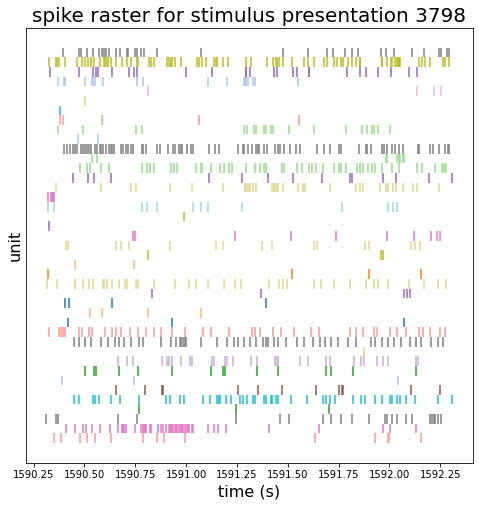

color                                                null
contrast                                              0.8
frame                                                null
orientation                                           135
phase                    [42471.86666667, 42471.86666667]
size                                       [250.0, 250.0]
spatial_frequency                                    0.04
start_time                                        1590.31
stimulus_block                                          2
stimulus_name                           drifting_gratings
stop_time                                         1592.31
temporal_frequency                                      4
x_position                                           null
y_position                                           null
duration                                          2.00171
stimulus_condition_id                                 246
Name: 3798, dtype: object

In [62]:
from allensdk.brain_observatory.ecephys.visualization import _VlPlotter

def raster_plot_try(spike_times, figsize=(8,8), cmap=plt.cm.tab20, title='spike raster', cycle_colors=False):

    fig, ax = plt.subplots(figsize=figsize)
    plotter = _VlPlotter(ax, num_objects=len(spike_times['unit_id'].unique()), cmap=cmap, cycle_colors=cycle_colors)
    # aggregate is called on each column, so pass only one (eg the stimulus_presentation_id)
    # to plot each unit once
    spike_times[['stimulus_presentation_id', 'unit_id']].groupby('unit_id').agg(plotter)
    
    ax.set_xlabel('time (s)', fontsize=16)
    ax.set_ylabel('unit', fontsize=16)
    ax.set_title(title, fontsize=20)
    
    plt.yticks([])
    plt.axis('tight')
    
    return fig

first_drifting_grating_presentation_id = times['stimulus_presentation_id'].values[0]
plot_times = times[times['stimulus_presentation_id'] == first_drifting_grating_presentation_id]

print(plot_times.head())
print(plot_times.shape)
a = plot_times[['stimulus_presentation_id', 'unit_id']].groupby('unit_id')
print(a.head())
# print(a.shape)

fig = raster_plot_try(plot_times, title=f'spike raster for stimulus presentation {first_drifting_grating_presentation_id}')
plt.show()

# also print out this presentation
session.stimulus_presentations.loc[first_drifting_grating_presentation_id]

In [55]:
session.stimulus_presentations.head()

color contrast frame orientation  \
stimulus_presentation_id                                    
0                         null     null  null        null   
1                         null      0.8  null          90   
2                         null      0.8  null          45   
3                         null      0.8  null          45   
4                         null      0.8  null           0   

                                                   phase          size  \
stimulus_presentation_id                                                 
0                                                   null          null   
1                         [3644.93333333, 3644.93333333]  [20.0, 20.0]   
2                         [3644.93333333, 3644.93333333]  [20.0, 20.0]   
3                         [3644.93333333, 3644.93333333]  [20.0, 20.0]   
4                         [3644.93333333, 3644.93333333]  [20.0, 20.0]   

                         spatial_frequency  start_time stimulus_block  \
stimulus_presentation_id                                                
0                                     null   29.005689           null   
1                                     0.08   89.072529              0   
2                                     0.08   89.306050              0   
3                                     0.08   89.556250              0   
4                                     0.08   89.806451              0   

                         stimulus_name  stop_time temporal_frequency  \
stimulus_presentation_id                                               
0                          spontaneous  89.072529               null   
1                               gabors  89.306050                  4   
2                               gabors  89.556250                  4   
3                               gabors  89.806451                  4   
4                               gabors  90.056651                  4   

                         x_position y_position   duration  \
stimulus_presentation_id                                    
0                              null       null  60.066840   
1                               -10         20   0.233521   
2                                20        -10   0.250201   
3                               -40        -20   0.250201   
4                                10          0   0.250201   

                          stimulus_condition_id  
stimulus_presentation_id                         
0                                             0  
1                                             1  
2                                             2  
3                                             3  
4                                             4

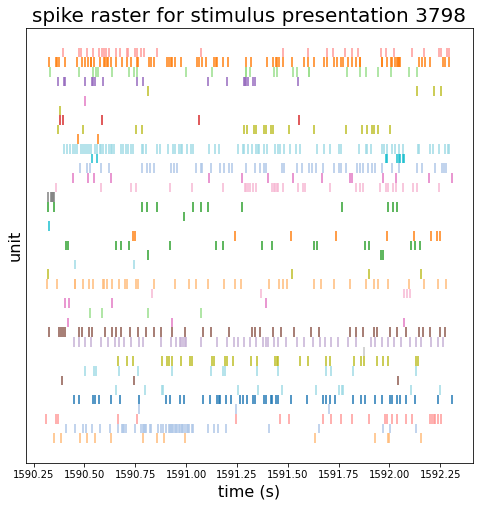

color                                                null
contrast                                              0.8
frame                                                null
orientation                                           135
phase                    [42471.86666667, 42471.86666667]
size                                       [250.0, 250.0]
spatial_frequency                                    0.04
start_time                                        1590.31
stimulus_block                                          2
stimulus_name                           drifting_gratings
stop_time                                         1592.31
temporal_frequency                                      4
x_position                                           null
y_position                                           null
duration                                          2.00171
stimulus_condition_id                                 246
Name: 3798, dtype: object

In [50]:
first_drifting_grating_presentation_id = times['stimulus_presentation_id'].values[0]
plot_times = times[times['stimulus_presentation_id'] == first_drifting_grating_presentation_id]

fig = raster_plot(plot_times, title=f'spike raster for stimulus presentation {first_drifting_grating_presentation_id}')
plt.show()

# also print out this presentation
session.stimulus_presentations.loc[first_drifting_grating_presentation_id]

We can access summary spike statistics for stimulus conditions and unit

In [63]:
stats = session.conditionwise_spike_statistics(
    stimulus_presentation_ids=drifting_gratings_presentation_ids,
    unit_ids=high_snr_unit_ids
)

stats.head()

spike_count  stimulus_presentation_count  \
unit_id   stimulus_condition_id                                             
951088345 246                              1                           15   
951088986 246                            193                           15   
951089019 246                            679                           15   
951089081 246                            184                           15   
951089233 246                            768                           15   

                                 spike_mean  spike_std  spike_sem  
unit_id   stimulus_condition_id                                    
951088345 246                      0.066667   0.258199   0.066667  
951088986 246                     12.866667   9.077969   2.343922  
951089019 246                     45.266667  13.509080   3.488029  
951089081 246                     12.266667  14.776751   3.815341  
951089233 246                     51.200000  14.688188   3.792474

In [64]:
stats = session.conditionwise_spike_statistics(
    stimulus_presentation_ids=drifting_gratings_presentation_ids,
    unit_ids=high_snr_unit_ids
)

# display the parameters associated with each condition
stats = pd.merge(stats, session.stimulus_conditions, left_on="stimulus_condition_id", right_index=True)

stats.head()

spike_count  stimulus_presentation_count  \
unit_id   stimulus_condition_id                                             
951088345 246                              1                           15   
951088986 246                            193                           15   
951089019 246                            679                           15   
951089081 246                            184                           15   
951089233 246                            768                           15   

                                 spike_mean  spike_std  spike_sem color  \
unit_id   stimulus_condition_id                                           
951088345 246                      0.066667   0.258199   0.066667  null   
951088986 246                     12.866667   9.077969   2.343922  null   
951089019 246                     45.266667  13.509080   3.488029  null   
951089081 246                     12.266667  14.776751   3.815341  null   
951089233 246                     51.200000  14.688188   3.792474  null   

                                contrast frame  mask opacity orientation  \
unit_id   stimulus_condition_id                                            
951088345 246                        0.8  null  None       1         135   
951088986 246                        0.8  null  None       1         135   
951089019 246                        0.8  null  None       1         135   
951089081 246                        0.8  null  None       1         135   
951089233 246                        0.8  null  None       1         135   

                                                            phase  \
unit_id   stimulus_condition_id                                     
951088345 246                    [42471.86666667, 42471.86666667]   
951088986 246                    [42471.86666667, 42471.86666667]   
951089019 246                    [42471.86666667, 42471.86666667]   
951089081 246                    [42471.86666667, 42471.86666667]   
951089233 246                    [42471.86666667, 42471.86666667]   

                                           size spatial_frequency  \
unit_id   stimulus_condition_id                                     
951088345 246                    [250.0, 250.0]              0.04   
951088986 246                    [250.0, 250.0]              0.04   
951089019 246                    [250.0, 250.0]              0.04   
951089081 246                    [250.0, 250.0]              0.04   
951089233 246                    [250.0, 250.0]              0.04   

                                     stimulus_name temporal_frequency units  \
unit_id   stimulus_condition_id                                               
951088345 246                    drifting_gratings                  4   deg   
951088986 246                    drifting_gratings                  4   deg   
951089019 246                    drifting_gratings                  4   deg   
951089081 246                    drifting_gratings                  4   deg   
951089233 246                    drifting_gratings                  4   deg   

                                x_position y_position    color_triplet  
unit_id   stimulus_condition_id                                         
951088345 246                         null       null  [1.0, 1.0, 1.0]  
951088986 246                         null       null  [1.0, 1.0, 1.0]  
951089019 246                         null       null  [1.0, 1.0, 1.0]  
951089081 246                         null       null  [1.0, 1.0, 1.0]  
951089233 246                         null       null  [1.0, 1.0, 1.0]

Using these data, we can ask for each unit: which stimulus condition evoked the most activity on average?

In [65]:
with_repeats = stats[stats["stimulus_presentation_count"] >= 5]
with_repeats.head()

spike_count  stimulus_presentation_count  \
unit_id   stimulus_condition_id                                             
951088345 246                              1                           15   
951088986 246                            193                           15   
951089019 246                            679                           15   
951089081 246                            184                           15   
951089233 246                            768                           15   

                                 spike_mean  spike_std  spike_sem color  \
unit_id   stimulus_condition_id                                           
951088345 246                      0.066667   0.258199   0.066667  null   
951088986 246                     12.866667   9.077969   2.343922  null   
951089019 246                     45.266667  13.509080   3.488029  null   
951089081 246                     12.266667  14.776751   3.815341  null   
951089233 246                     51.200000  14.688188   3.792474  null   

                                contrast frame  mask opacity orientation  \
unit_id   stimulus_condition_id                                            
951088345 246                        0.8  null  None       1         135   
951088986 246                        0.8  null  None       1         135   
951089019 246                        0.8  null  None       1         135   
951089081 246                        0.8  null  None       1         135   
951089233 246                        0.8  null  None       1         135   

                                                            phase  \
unit_id   stimulus_condition_id                                     
951088345 246                    [42471.86666667, 42471.86666667]   
951088986 246                    [42471.86666667, 42471.86666667]   
951089019 246                    [42471.86666667, 42471.86666667]   
951089081 246                    [42471.86666667, 42471.86666667]   
951089233 246                    [42471.86666667, 42471.86666667]   

                                           size spatial_frequency  \
unit_id   stimulus_condition_id                                     
951088345 246                    [250.0, 250.0]              0.04   
951088986 246                    [250.0, 250.0]              0.04   
951089019 246                    [250.0, 250.0]              0.04   
951089081 246                    [250.0, 250.0]              0.04   
951089233 246                    [250.0, 250.0]              0.04   

                                     stimulus_name temporal_frequency units  \
unit_id   stimulus_condition_id                                               
951088345 246                    drifting_gratings                  4   deg   
951088986 246                    drifting_gratings                  4   deg   
951089019 246                    drifting_gratings                  4   deg   
951089081 246                    drifting_gratings                  4   deg   
951089233 246                    drifting_gratings                  4   deg   

                                x_position y_position    color_triplet  
unit_id   stimulus_condition_id                                         
951088345 246                         null       null  [1.0, 1.0, 1.0]  
951088986 246                         null       null  [1.0, 1.0, 1.0]  
951089019 246                         null       null  [1.0, 1.0, 1.0]  
951089081 246                         null       null  [1.0, 1.0, 1.0]  
951089233 246                         null       null  [1.0, 1.0, 1.0]

In [66]:
with_repeats = stats[stats["stimulus_presentation_count"] >= 5]

highest_mean_rate = lambda df: df.loc[df['spike_mean'].idxmax()]
max_rate_conditions = with_repeats.groupby('unit_id').apply(highest_mean_rate)
max_rate_conditions.head()

spike_count  stimulus_presentation_count  spike_mean  spike_std  \
unit_id                                                                      
951088345           17                           15    1.133333   2.030717   
951088986          286                           15   19.066667   8.128140   
951089019          809                           15   53.933333  11.907181   
951089081          386                           15   25.733333  13.519651   
951089233         1500                           15  100.000000  25.657079   

           spike_sem color contrast frame  mask  opacity orientation  \
unit_id                                                                
951088345   0.524329  null      0.8  null  None      1.0         315   
951088986   2.098677  null      0.8  null  None      1.0          90   
951089019   3.074421  null      0.8  null  None      1.0         180   
951089081   3.490759  null      0.8  null  None      1.0         225   
951089233   6.624629  null      0.8  null  None      1.0          45   

                                      phase            size spatial_frequency  \
unit_id                                                                         
951088345  [42471.86666667, 42471.86666667]  [250.0, 250.0]              0.04   
951088986  [42471.86666667, 42471.86666667]  [250.0, 250.0]              0.04   
951089019  [42471.86666667, 42471.86666667]  [250.0, 250.0]              0.04   
951089081  [42471.86666667, 42471.86666667]  [250.0, 250.0]              0.04   
951089233  [42471.86666667, 42471.86666667]  [250.0, 250.0]              0.04   

               stimulus_name temporal_frequency units x_position y_position  \
unit_id                                                                       
951088345  drifting_gratings                  1   deg       null       null   
951088986  drifting_gratings                  1   deg       null       null   
951089019  drifting_gratings                  2   deg       null       null   
951089081  drifting_gratings                  1   deg       null       null   
951089233  drifting_gratings                  8   deg       null       null   

             color_triplet  
unit_id                     
951088345  [1.0, 1.0, 1.0]  
951088986  [1.0, 1.0, 1.0]  
951089019  [1.0, 1.0, 1.0]  
951089081  [1.0, 1.0, 1.0]  
951089233  [1.0, 1.0, 1.0]

### Spike histograms

It is commonly useful to compare spike data from across units and stimulus presentations, all relative to the onset of a stimulus presentation. We can do this using the `presentationwise_spike_counts` method. 

In [67]:
# We're going to build an array of spike counts surrounding stimulus presentation onset
# To do that, we will need to specify some bins (in seconds, relative to stimulus onset)
time_bin_edges = np.linspace(-0.01, 0.4, 200)

# look at responses to the flash stimulus
flash_250_ms_stimulus_presentation_ids = session.stimulus_presentations[
    session.stimulus_presentations['stimulus_name'] == 'flashes'
].index.values

# and get a set of units with only decent snr
decent_snr_unit_ids = session.units[
    session.units['snr'] >= 1.5
].index.values

spike_counts_da = session.presentationwise_spike_counts(
    bin_edges=time_bin_edges,
    stimulus_presentation_ids=flash_250_ms_stimulus_presentation_ids,
    unit_ids=decent_snr_unit_ids
)
spike_counts_da

<xarray.DataArray 'spike_counts' (stimulus_presentation_id: 150, time_relative_to_stimulus_onset: 199, unit_id: 544)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3647 ... 3796
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 -0.00897 ... 0.399
  * unit_id                          (unit_id) int64 951087020 ... 951108231

This has returned a new (to this notebook) data structure, the `xarray.DataArray`. You can think of this as similar to a 3+D `pandas.DataFrame`, or as a `numpy.ndarray` with labeled axes and indices. See the [xarray documentation](http://xarray.pydata.org/en/stable/index.html) for more information. In the mean time, the salient features are:

- Dimensions : Each axis on each data variable is associated with a named dimension. This lets us see unambiguously what the axes of our array mean.
- Coordinates : Arrays of labels for each sample on each dimension.

xarray is nice because it forces code to be explicit about dimensions and coordinates, improving readability and avoiding bugs. However, you can always convert to numpy or pandas data structures as follows:
- to pandas: `spike_counts_ds.to_dataframe()` produces a multiindexed dataframe
- to numpy: `spike_counts_ds.values` gives you access to the underlying numpy array

We can now plot spike counts for a particular presentation:

In [69]:
presentation_id = 3796
spike_counts_da.loc[{'stimulus_presentation_id': presentation_id}]

<xarray.DataArray 'spike_counts' (time_relative_to_stimulus_onset: 199, unit_id: 544)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Coordinates:
    stimulus_presentation_id         int64 3796
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 -0.00897 ... 0.399
  * unit_id                          (unit_id) int64 951087020 ... 951108231

In [70]:
spike_counts_da['time_relative_to_stimulus_onset']

<xarray.DataArray 'time_relative_to_stimulus_onset' (time_relative_to_stimulus_onset: 199)>
array([-0.00897 , -0.00691 , -0.004849, -0.002789, -0.000729,  0.001332,
        0.003392,  0.005452,  0.007513,  0.009573,  0.011633,  0.013693,
        0.015754,  0.017814,  0.019874,  0.021935,  0.023995,  0.026055,
        0.028116,  0.030176,  0.032236,  0.034296,  0.036357,  0.038417,
        0.040477,  0.042538,  0.044598,  0.046658,  0.048719,  0.050779,
        0.052839,  0.054899,  0.05696 ,  0.05902 ,  0.06108 ,  0.063141,
        0.065201,  0.067261,  0.069322,  0.071382,  0.073442,  0.075503,
        0.077563,  0.079623,  0.081683,  0.083744,  0.085804,  0.087864,
        0.089925,  0.091985,  0.094045,  0.096106,  0.098166,  0.100226,
        0.102286,  0.104347,  0.106407,  0.108467,  0.110528,  0.112588,
        0.114648,  0.116709,  0.118769,  0.120829,  0.122889,  0.12495 ,
        0.12701 ,  0.12907 ,  0.131131,  0.133191,  0.135251,  0.137312,
        0.139372,  0.141432,  0.143492,  0.145553,  0.147613,  0.149673,
        0.151734,  0.153794,  0.155854,  0.157915,  0.159975,  0.162035,
        0.164095,  0.166156,  0.168216,  0.170276,  0.172337,  0.174397,
        0.176457,  0.178518,  0.180578,  0.182638,  0.184698,  0.186759,
        0.188819,  0.190879,  0.19294 ,  0.195   ,  0.19706 ,  0.199121,
        0.201181,  0.203241,  0.205302,  0.207362,  0.209422,  0.211482,
        0.213543,  0.215603,  0.217663,  0.219724,  0.221784,  0.223844,
        0.225905,  0.227965,  0.230025,  0.232085,  0.234146,  0.236206,
        0.238266,  0.240327,  0.242387,  0.244447,  0.246508,  0.248568,
        0.250628,  0.252688,  0.254749,  0.256809,  0.258869,  0.26093 ,
        0.26299 ,  0.26505 ,  0.267111,  0.269171,  0.271231,  0.273291,
        0.275352,  0.277412,  0.279472,  0.281533,  0.283593,  0.285653,
        0.287714,  0.289774,  0.291834,  0.293894,  0.295955,  0.298015,
        0.300075,  0.302136,  0.304196,  0.306256,  0.308317,  0.310377,
        0.312437,  0.314497,  0.316558,  0.318618,  0.320678,  0.322739,
        0.324799,  0.326859,  0.32892 ,  0.33098 ,  0.33304 ,  0.335101,
        0.337161,  0.339221,  0.341281,  0.343342,  0.345402,  0.347462,
        0.349523,  0.351583,  0.353643,  0.355704,  0.357764,  0.359824,
        0.361884,  0.363945,  0.366005,  0.368065,  0.370126,  0.372186,
        0.374246,  0.376307,  0.378367,  0.380427,  0.382487,  0.384548,
        0.386608,  0.388668,  0.390729,  0.392789,  0.394849,  0.39691 ,
        0.39897 ])
Coordinates:
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 -0.00897 ... 0.399

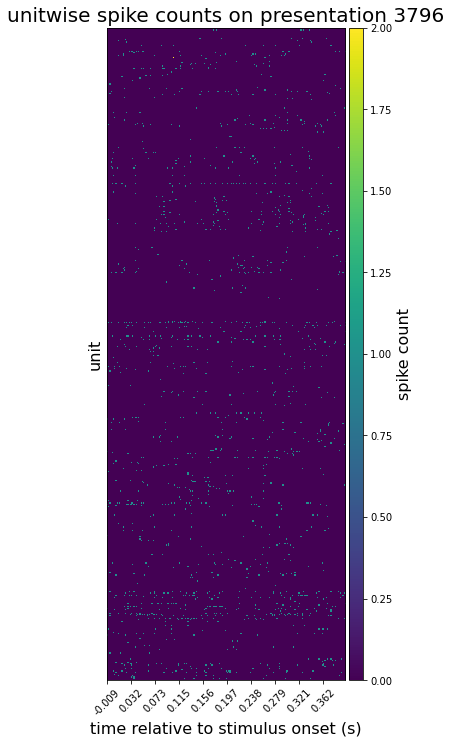

In [71]:
presentation_id = 3796 # chosen arbitrarily
plot_spike_counts(
    spike_counts_da.loc[{'stimulus_presentation_id': presentation_id}], 
    spike_counts_da['time_relative_to_stimulus_onset'],
    'spike count', 
    f'unitwise spike counts on presentation {presentation_id}'
)
plt.show()

We can also average across all presentations, adding a new data array to the dataset. Notice that this one no longer has a stimulus_presentation_id dimension, as we have collapsed it by averaging.

In [72]:
mean_spike_counts = spike_counts_da.mean(dim='stimulus_presentation_id')
mean_spike_counts

<xarray.DataArray 'spike_counts' (time_relative_to_stimulus_onset: 199, unit_id: 544)>
array([[0.01333333, 0.        , 0.04      , ..., 0.        , 0.00666667,
        0.        ],
       [0.00666667, 0.        , 0.01333333, ..., 0.        , 0.00666667,
        0.00666667],
       [0.01333333, 0.        , 0.00666667, ..., 0.00666667, 0.00666667,
        0.        ],
       ...,
       [0.01333333, 0.        , 0.02666667, ..., 0.        , 0.01333333,
        0.        ],
       [0.01333333, 0.        , 0.02      , ..., 0.        , 0.01333333,
        0.        ],
       [0.00666667, 0.        , 0.00666667, ..., 0.        , 0.00666667,
        0.        ]])
Coordinates:
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 -0.00897 ... 0.399
  * unit_id                          (unit_id) int64 951087020 ... 951108231

... and plot the mean spike counts

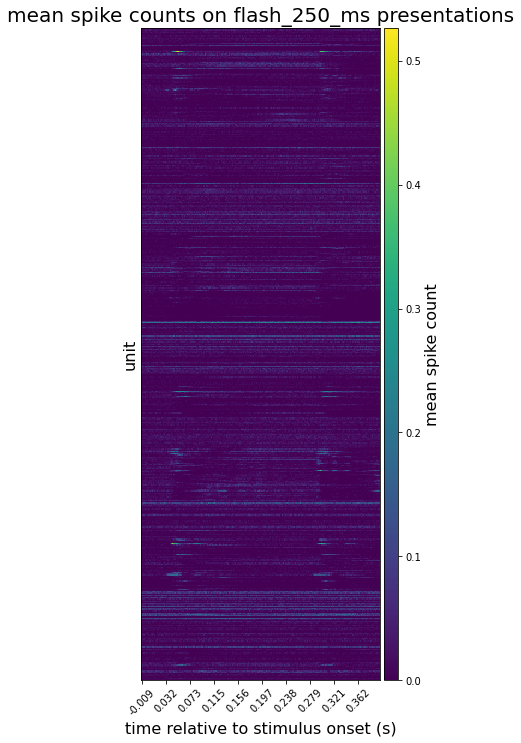

In [73]:
plot_spike_counts(
    mean_spike_counts, 
    mean_spike_counts['time_relative_to_stimulus_onset'],
    'mean spike count', 
    'mean spike counts on flash_250_ms presentations'
)
plt.show()

### Waveforms

We store precomputed mean waveforms for each unit in the `mean_waveforms` attribute on the `EcephysSession` object. This is a dictionary which maps unit ids to xarray [DataArrays](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html). These have `channel` and `time` (seconds, aligned to the detected event times) dimensions. The data values are in microvolts, as measured at the recording site.

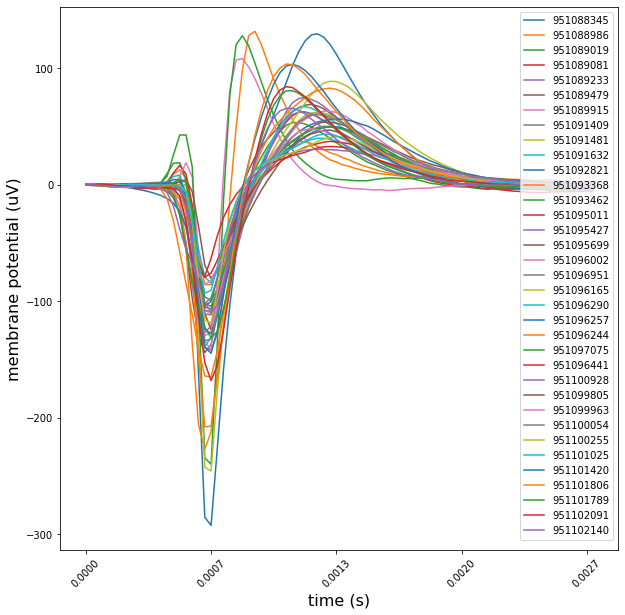

In [74]:
units_of_interest = high_snr_unit_ids[:35]

waveforms = {uid: session.mean_waveforms[uid] for uid in units_of_interest}
peak_channels = {uid: session.units.loc[uid, 'peak_channel_id'] for uid in units_of_interest}

# plot the mean waveform on each unit's peak channel/
plot_mean_waveforms(waveforms, units_of_interest, peak_channels)
plt.show()

Since neuropixels probes are densely populated with channels, spikes are typically detected on several channels. We can see this by plotting mean waveforms on channels surrounding a unit's peak channel:

In [75]:
uid = units_of_interest[12]
unit_waveforms = waveforms[uid]
peak_channel = peak_channels[uid]
print(unit_waveforms)
print(peak_channel)

<xarray.DataArray (channel_id: 374, time: 82)>
array([[ 0.      , -0.926835, -0.2418  , ..., -1.207635, -1.52295 ,
         0.47892 ],
       [ 0.      ,  0.1131  , -0.20163 , ..., -0.715455, -0.708045,
        -0.66846 ],
       [ 0.      ,  0.092625, -0.28041 , ..., -0.727545, -0.68289 ,
        -0.58422 ],
       ...,
       [ 0.      ,  0.18603 ,  0.641745, ..., -0.046995,  0.05031 ,
         0.212355],
       [ 0.      ,  0.093795,  0.608985, ..., -0.30225 , -0.01911 ,
         0.21528 ],
       [ 0.      ,  0.348075,  1.00581 , ...,  0.05343 ,  0.498225,
         0.79131 ]])
Coordinates:
  * channel_id  (channel_id) int32 849845190 849845192 ... 849845954 849845956
  * time        (time) float64 0.0 3.333e-05 6.667e-05 ... 0.002667 0.0027
849845346


In [79]:
print(np.where(unit_waveforms["channel_id"] == peak_channel))

print(np.where(unit_waveforms["channel_id"] == peak_channel)[0])

print(np.where(unit_waveforms["channel_id"] == peak_channel)[0][0])

(array([76], dtype=int64),)
[76]
76


In [80]:
uid = units_of_interest[12]
unit_waveforms = waveforms[uid]
peak_channel = peak_channels[uid]
peak_channel_idx = np.where(unit_waveforms["channel_id"] == peak_channel)[0][0]

In [82]:
ch_min = max(peak_channel_idx - 10, 0)
ch_max = min(peak_channel_idx + 10, len(unit_waveforms["channel_id"]) - 1)
surrounding_channels = unit_waveforms["channel_id"][np.arange(ch_min, ch_max, 2)] 
print(surrounding_channels)

<xarray.DataArray 'channel_id' (channel_id: 10)>
array([849845324, 849845328, 849845332, 849845336, 849845342, 849845346,
       849845350, 849845354, 849845358, 849845362])
Coordinates:
  * channel_id  (channel_id) int32 849845324 849845328 ... 849845358 849845362


In [83]:
unit_waveforms.loc[{"channel_id": surrounding_channels}]

<xarray.DataArray (channel_id: 10, time: 82)>
array([[ 0.00000000e+00,  2.25810000e-01,  1.21095000e-01,
        -1.91295000e-01, -6.25950000e-02, -1.07640000e-01,
        -1.97535000e-01, -2.69880000e-01, -3.87465000e-01,
        -6.35895000e-01, -8.63850000e-01, -1.28485500e+00,
        -1.46835000e+00, -9.85530000e-01, -6.78210000e-01,
        -8.62680000e-01, -3.88791000e+00, -7.31328000e+00,
        -7.03189500e+00, -4.11333000e+00, -2.35131000e+00,
        -1.82539500e+00, -1.51027500e+00, -1.14387000e+00,
        -5.97675000e-01,  9.86115000e-01,  2.35950000e-01,
        -2.65746000e+00, -3.36648000e+00, -2.07460500e+00,
         1.03350000e-02,  1.52275500e+00,  2.09254500e+00,
         2.41800000e+00,  2.45310000e+00,  2.11360500e+00,
         1.96833000e+00,  1.16980500e+00,  9.43215000e-01,
         6.44280000e-01,  8.43180000e-01,  9.07530000e-01,
         4.80090000e-01,  7.34175000e-01,  9.36975000e-01,
         1.17643500e+00,  1.42038000e+00,  1.78834500e+00,
         1.80472500e+00,  2.15982000e+00,  2.08162500e+00,
         1.88038500e+00,  2.25693000e+00,  2.79513000e+00,
         3.31519500e+00,  2.98077000e+00,  3.11629500e+00,
         3.29413500e+00,  3.27580500e+00,  3.11025000e+00,
         3.30213000e+00,  3.58878000e+00,  3.33742500e+00,
         3.15705000e+00,  3.32845500e+00,  3.25396500e+00,
         3.03868500e+00,  3.14223000e+00,  3.08841000e+00,
         3.47080500e+00,  3.52248000e+00,  3.51721500e+00,
         3.44584500e+00,  3.10186500e+00,  2.66292000e+00,
         3.14613000e+00,  3.44682000e+00,  3.46729500e+00,
         3.22179000e+00,  3.13384500e+00,  3.19059000e+00,
         3.37174500e+00],
       [ 0.00000000e+00,  9.34050000e-02,  5.85390000e-01,
         2.88600000e-02,  2.35365000e-01,  1.40790000e-01,
         4.93350000e-02, -1.72575000e-01, -3.35400000e-01,
        -3.14145000e-01, -1.20900000e-01, -3.67575000e-01,
        -8.00280000e-01, -3.59190000e-01,  5.29035000e-01,
         1.53465000e-01, -3.71689500e+00, -8.13988500e+00,
        -7.79025000e+00, -5.19889500e+00, -3.19624500e+00,
        -9.43215000e-01,  1.19554500e+00,  2.77446000e+00,
         1.50715500e+00, -2.00323500e+00, -5.31472500e+00,
        -6.59782500e+00, -4.85530500e+00, -1.73823000e+00,
         1.44339000e+00,  3.71826000e+00,  4.67161500e+00,
         5.09847000e+00,  4.43878500e+00,  4.05132000e+00,
         3.38910000e+00,  2.96751000e+00,  2.77017000e+00,
         2.39596500e+00,  2.17152000e+00,  2.24172000e+00,
         2.25966000e+00,  2.76997500e+00,  2.96146500e+00,
         3.48777000e+00,  3.30310500e+00,  3.00144000e+00,
         3.13872000e+00,  3.29316000e+00,  3.89668500e+00,
         3.82921500e+00,  4.19874000e+00,  4.33231500e+00,
         4.61643000e+00,  4.84419000e+00,  4.62696000e+00,
         4.61019000e+00,  4.62169500e+00,  4.38282000e+00,
         4.54447500e+00,  4.63144500e+00,  4.56573000e+00,
         4.61877000e+00,  4.37248500e+00,  4.30852500e+00,
         3.78339000e+00,  3.54295500e+00,  3.73854000e+00,
         3.81751500e+00,  3.95811000e+00,  3.97722000e+00,
         3.60828000e+00,  3.57513000e+00,  3.41269500e+00,
         3.73113000e+00,  4.00081500e+00,  3.77442000e+00,
         3.62095500e+00,  3.53535000e+00,  3.38988000e+00,
         3.37486500e+00],
       [ 0.00000000e+00,  5.66865000e-01,  4.20030000e-01,
        -3.03030000e-01, -1.46250000e-01,  2.88405000e-01,
         1.35135000e-01, -6.16200000e-02, -6.18345000e-01,
        -6.46815000e-01, -1.43910000e-01, -8.19000000e-02,
         8.61900000e-02,  1.17000000e+00,  1.89540000e+00,
         1.04559000e+00, -4.42006500e+00, -1.25737950e+01,
        -1.57072500e+01, -1.37437950e+01, -9.07783500e+00,
        -3.80308500e+00,  2.88151500e+00,  6.64150500e+00,
         3.73581000e+00, -4.13361000e+00, -9.28375500e+00,
        -7.21266000e+00, -1.36909500e+00,  4.68604500e+00,
         7.78986000e+00,  9.21082500e+00,  8.73658500e+00,
         7.42092000e+00,  6.67660500e+00,  6.39775500e+00,
        

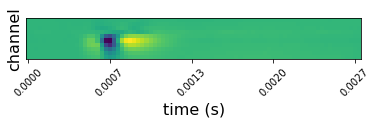

In [86]:

fig, ax = plt.subplots()
ax.imshow(unit_waveforms.loc[{"channel_id": surrounding_channels}])

ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_ylabel("channel", fontsize=16)

ax.set_xticks(np.arange(0, len(unit_waveforms['time']), 20))
ax.set_xticklabels([f'{float(ii):1.4f}' for ii in unit_waveforms['time'][::20]], rotation=45)
ax.set_xlabel("time (s)", fontsize=16)

plt.show()

### Running speed

We can obtain the velocity at which the experimental subject ran as a function of time by accessing the `running_speed` attribute. This returns a pandas dataframe whose rows are intervals of time (defined by "start_time" and "end_time" columns), and whose "velocity" column contains mean running speeds within those intervals.

Here we'll plot the running speed trace for an arbitrary chunk of time.

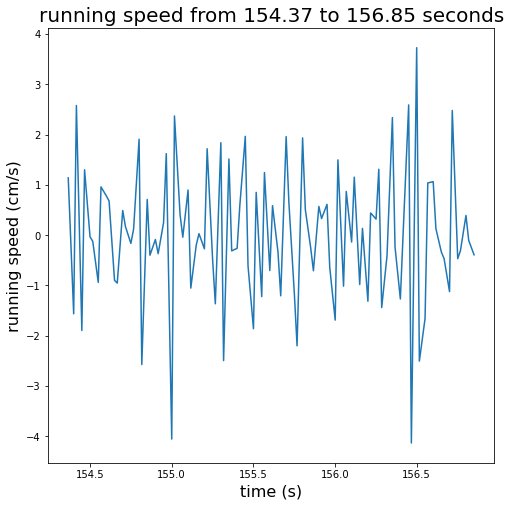

In [87]:
running_speed_midpoints = session.running_speed["start_time"] + \
    (session.running_speed["end_time"] - session.running_speed["start_time"]) / 2
plot_running_speed(
    running_speed_midpoints, 
    session.running_speed["velocity"], 
    start_index=5000,
    stop_index=5100
)
plt.show()

### Optogenetic stimulation

In [88]:
session.optogenetic_stimulation_epochs

start_time                     condition  level    stop_time  \
id                                                                   
0     9800.88204         a single square pulse    1.3   9800.88704   
1     9802.87211         a single square pulse    2.0   9802.88211   
2     9804.90224         a single square pulse    1.3   9804.90724   
3     9807.03234  half-period of a cosine wave    1.7   9808.03234   
4     9809.17240        2.5 ms pulses at 10 Hz    1.3   9810.17240   
..           ...                           ...    ...          ...   
295  10367.42684         a single square pulse    1.3  10367.43684   
296  10369.18687         a single square pulse    1.7  10369.19687   
297  10371.02692  half-period of a cosine wave    2.0  10372.02692   
298  10373.02701         a single square pulse    2.0  10373.03201   
299  10375.11706         a single square pulse    1.7  10375.12706   

     stimulus_name  duration  
id                            
0            pulse     0.005  
1            pulse     0.010  
2            pulse     0.005  
3    raised_cosine     1.000  
4      fast_pulses     1.000  
..             ...       ...  
295          pulse     0.010  
296          pulse     0.010  
297  raised_cosine     1.000  
298          pulse     0.005  
299          pulse     0.010  

[300 rows x 6 columns]

### Eye tracking ellipse fits and estimated screen gaze location

Ecephys sessions may contain eye tracking data in the form of ellipse fits and estimated screen gaze location. Let's look at the ellipse fits first:

In [89]:
pupil_data = session.get_pupil_data()
pupil_data

corneal_reflection_center_x  corneal_reflection_center_y  \
Time (s)                                                                
3.12230                       326.706811                   204.010857   
3.14975                       326.610078                   203.826322   
3.16384                       326.547090                   204.363441   
3.19712                       326.522452                   204.125732   
3.23045                       326.516206                   203.892135   
...                                  ...                          ...   
10681.20424                   330.344497                   195.744961   
10681.23760                   334.196630                   199.297023   
10681.27101                   337.929215                   202.415632   
10681.30418                   338.804572                   201.732339   
10681.33860                   339.406264                   200.978589   

             corneal_reflection_height  corneal_reflection_width  \
Time (s)                                                           
3.12230                      17.856378                 16.198974   
3.14975                      17.333181                 16.150731   
3.16384                      16.755811                 16.037298   
3.19712                      16.698028                 15.403655   
3.23045                      16.691945                 15.330934   
...                                ...                       ...   
10681.20424                  13.565715                 14.797591   
10681.23760                  15.266689                 17.358142   
10681.27101                  16.363472                 18.600890   
10681.30418                  17.503076                 19.254618   
10681.33860                  16.422517                 19.777207   

             corneal_reflection_phi  pupil_center_x  pupil_center_y  \
Time (s)                                                              
3.12230                    0.226572      331.864117      146.081447   
3.14975                    0.355684      331.358476      146.054381   
3.16384                   -0.050942      331.469305      145.994836   
3.19712                    0.267105      331.038158      145.472633   
3.23045                    0.248586      330.777366      145.429702   
...                             ...             ...             ...   
10681.20424                0.722065      328.605042      152.318670   
10681.23760                0.110869             NaN             NaN   
10681.27101               -0.016696             NaN             NaN   
10681.30418               -0.243761      349.193968      160.737100   
10681.33860               -0.374468             NaN             NaN   

             pupil_height  pupil_width  pupil_phi  eye_center_x  eye_center_y  \
Time (s)                                                                        
3.12230         93.520302   121.464657   0.126109    310.614320    180.504614   
3.14975         93.953658   122.917744   0.119819    310.392891    180.816726   
3.16384         93.767485   122.836975   0.125750    311.046869    180.689895   
3.19712         94.079254   122.439746   0.120794    311.380259    180.572092   
3.23045         93.366674   122.641229   0.118402    311.607057    180.574411   
...                   ...          ...        ...           ...           ...   
10681.20424    119.109059   177.349302   0.093844    308.067123    186.213882   
10681.23760           NaN          NaN        NaN    310.489389    184.051675   
10681.27101           NaN          NaN        NaN    312.651981    186.923312   
10681.30418    115.425276   182.170780   0.373188    312.993389    188.435079   
10681.33860           NaN          NaN        NaN    313.818432    187.698249   

             eye_height   eye_width   eye_phi  
Time (s)                                       
3.12230      254.057482  325.622566  0.043156  
3.14975      255.241941  325.534338  0.033997  
3.16384 

This particular session has eye tracking data, let's try plotting the ellipse fits over time.

In [90]:
%%capture
from matplotlib import animation
from matplotlib.patches import Ellipse

def plot_animated_ellipse_fits(pupil_data: pd.DataFrame, start_frame: int, end_frame: int):

    start_frame = 0 if (start_frame < 0) else start_frame
    end_frame = len(pupil_data) if (end_frame > len(pupil_data)) else end_frame
    
    frame_times = pupil_data.index.values[start_frame:end_frame]
    interval = np.average(np.diff(frame_times)) * 1000

    fig = plt.figure()
    ax = plt.axes(xlim=(0, 480), ylim=(0, 480))

    cr_ellipse = Ellipse((0, 0), width=0.0, height=0.0, angle=0, color='white')
    pupil_ellipse = Ellipse((0, 0), width=0.0, height=0.0, angle=0, color='black')
    eye_ellipse = Ellipse((0, 0), width=0.0, height=0.0, angle=0, color='grey')

    ax.add_patch(eye_ellipse)
    ax.add_patch(pupil_ellipse)
    ax.add_patch(cr_ellipse)

    def update_ellipse(ellipse_patch, ellipse_frame_vals: pd.DataFrame, prefix: str):
        ellipse_patch.center = tuple(ellipse_frame_vals[[f"{prefix}_center_x", f"{prefix}_center_y"]].values)
        ellipse_patch.width = ellipse_frame_vals[f"{prefix}_width"]
        ellipse_patch.height = ellipse_frame_vals[f"{prefix}_height"]
        ellipse_patch.angle = np.degrees(ellipse_frame_vals[f"{prefix}_phi"])
    
    def init():
        return [cr_ellipse, pupil_ellipse, eye_ellipse]

    def animate(i):
        ellipse_frame_vals = pupil_data.iloc[i]
        
        update_ellipse(cr_ellipse, ellipse_frame_vals, prefix="corneal_reflection")
        update_ellipse(pupil_ellipse, ellipse_frame_vals, prefix="pupil")
        update_ellipse(eye_ellipse, ellipse_frame_vals, prefix="eye")
        
        return [cr_ellipse, pupil_ellipse, eye_ellipse]
    
    return animation.FuncAnimation(fig, animate, init_func=init, interval=interval, frames=range(start_frame, end_frame), blit=True)

anim = plot_animated_ellipse_fits(pupil_data, 100, 600)

In [91]:
from IPython.display import HTML

HTML(anim.to_jshtml())

Using the above ellipse fits and location/orientation information about the experimental rigs, it is possible to calculate additional statistics such as pupil size or estimate a gaze location on screen at a given time. Due to the degrees of freedom in some rig components, gaze estimates have no accuracy guarantee. For additional information about the gaze mapping estimation process please refer to: https://github.com/AllenInstitute/AllenSDK/tree/master/allensdk/brain_observatory/gaze_mapping

In [92]:
gaze_data = session.get_screen_gaze_data()
gaze_data

raw_eye_area  raw_pupil_area  raw_screen_coordinates_x_cm  \
Time (s)                                                                 
3.12230          0.067598        0.012056                     6.637603   
3.14975          0.067895        0.012346                     6.613956   
3.16384          0.068140        0.012330                     6.686676   
3.19712          0.068165        0.012250                     6.715397   
3.23045          0.068098        0.012290                     6.689634   
...                   ...             ...                          ...   
10681.20424      0.071793        0.025701                     4.951233   
10681.23760           NaN             NaN                          NaN   
10681.27101           NaN             NaN                          NaN   
10681.30418      0.070380        0.027117                     4.810568   
10681.33860           NaN             NaN                          NaN   

             raw_screen_coordinates_y_cm  \
Time (s)                                   
3.12230                        -2.446273   
3.14975                        -2.403698   
3.16384                        -2.422880   
3.19712                        -2.381413   
3.23045                        -2.354732   
...                                  ...   
10681.20424                    -1.748558   
10681.23760                          NaN   
10681.27101                          NaN   
10681.30418                    -2.952154   
10681.33860                          NaN   

             raw_screen_coordinates_spherical_x_deg  \
Time (s)                                              
3.12230                                   23.594971   
3.14975                                   23.529435   
3.16384                                   23.755377   
3.19712                                   23.855200   
3.23045                                   23.779638   
...                                             ...   
10681.20424                               18.154232   
10681.23760                                     NaN   
10681.27101                                     NaN   
10681.30418                               17.468899   
10681.33860                                     NaN   

             raw_screen_coordinates_spherical_y_deg  
Time (s)                                             
3.12230                                   -9.263550  
3.14975                                   -9.105050  
3.16384                                   -9.176479  
3.19712                                   -9.022034  
3.23045                                   -8.922586  
...                                             ...  
10681.20424                               -6.649729  
10681.23760                                     NaN  
10681.27101                                     NaN  
10681.30418                              -11.135314  
10681.33860                                     NaN  

[320070 rows x 6 columns]

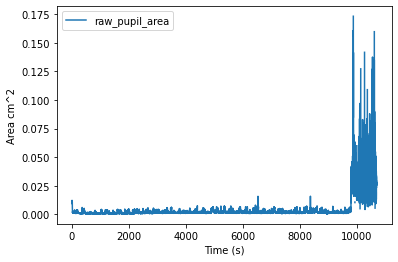

In [93]:
ax = gaze_data[["raw_pupil_area"]].plot()
_ = ax.set_ylabel("Area cm^2")

### Local Field Potential

We record local field potential on a subset of channels at 2500 Hz. Even subsampled and compressed, these data are quite large, so we store them seperately for each probe.

In [94]:
# list the probes recorded from in this session
session.probes.head()

description                 location  sampling_rate  \
id                                                              
805579698      probeA  See electrode locations   29999.960987   
805579700      probeB  See electrode locations   29999.914481   
805579703      probeC  See electrode locations   29999.993749   
805579706      probeD  See electrode locations   29999.918247   
805579710      probeE  See electrode locations   29999.998738   

           lfp_sampling_rate  has_lfp_data  
id                                          
805579698        1249.998374          True  
805579700        1249.996437          True  
805579703        1249.999740          True  
805579706        1249.996594          True  
805579710        1249.999947          True

In [95]:
# load up the lfp from one of the probes. This returns an xarray dataarray

probe_id = session.probes.index.values[0]

lfp = session.get_lfp(probe_id)
lfp

<xarray.DataArray 'LFP' (time: 13346411, channel: 96)>
array([[6.63000028e-05, 3.52950010e-05, 1.28700003e-05, ...,
        1.94999998e-07, 1.61850003e-05, 0.00000000e+00],
       [2.18400000e-05, 7.66349985e-05, 7.60499970e-05, ...,
        1.07249998e-05, 3.12000011e-05, 0.00000000e+00],
       [4.15350005e-05, 7.81950002e-05, 5.38200002e-05, ...,
        1.13099995e-05, 5.90849995e-05, 0.00000000e+00],
       ...,
       [1.35330003e-04, 1.93829997e-04, 2.45114992e-04, ...,
        8.59950014e-05, 1.25189996e-04, 0.00000000e+00],
       [1.48784995e-04, 2.26784992e-04, 2.66174990e-04, ...,
        4.27049999e-05, 8.07300021e-05, 0.00000000e+00],
       [8.85299960e-05, 1.77840004e-04, 1.90514998e-04, ...,
        2.41799989e-05, 6.49349968e-05, 0.00000000e+00]], dtype=float32)
Coordinates:
  * time     (time) float64 3.621 3.622 3.623 ... 1.068e+04 1.068e+04 1.068e+04
  * channel  (channel) int64 849847712 849847720 ... 849848464 849848472

We can figure out where each LFP channel is located in the brain

In [96]:
# now use a utility to associate intervals of /rows with structures
structure_acronyms, intervals = session.channel_structure_intervals(lfp["channel"])
interval_midpoints = [aa + (bb - aa) / 2 for aa, bb in zip(intervals[:-1], intervals[1:])]
print(structure_acronyms)
print(intervals)

['CA1' 'VISam' nan 'COAa']
[ 0 18 39 72 96]


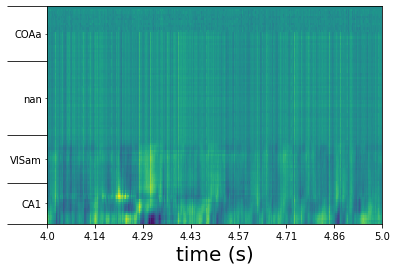

In [97]:
window = np.where(np.logical_and(lfp["time"] < 5.0, lfp["time"] >= 4.0))[0]

fig, ax = plt.subplots()
ax.pcolormesh(lfp[{"time": window}].T)

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints, minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
plt.tick_params("y", which="major", labelleft=False, length=40)

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(window), num_time_labels)).astype(int) - 1
time_labels = [ f"{val:1.3}" for val in lfp["time"].values[window][time_label_indices]]
ax.set_xticks(time_label_indices + 0.5)
ax.set_xticklabels(time_labels)
ax.set_xlabel("time (s)", fontsize=20)

plt.show()

### Current source density

We precompute current source density for each probe.

In [99]:
csd = session.get_current_source_density(probe_id)
csd

<xarray.DataArray 'CSD' (virtual_channel_index: 384, time: 875)>
array([[ -7991.56671166, -11249.67206952, -13857.4555376 , ...,
        -55647.27666854, -45334.4988889 , -34258.2019042 ],
       [  8589.43060401,  13335.40186638,  17662.89310557, ...,
         28744.2342393 ,  23101.78857787,  17037.38988715],
       [ 11966.58730028,  19025.74407907,  25489.06841197, ...,
         42145.39052183,  33693.34614689,  24624.37050078],
       ...,
       [  2103.2294137 ,  -2723.90170221,  -6896.28397089, ...,
         19048.18885164,  16046.52879681,  12597.12722604],
       [-76644.96187611, -63933.00412448, -52748.71581506, ...,
        -94459.62600965, -75694.78627361, -53993.34968945],
       [ 61063.77370669,  53111.54561727,  45907.09566837, ...,
         48671.70562975,  38463.5133122 ,  26541.28158342]])
Coordinates:
  * virtual_channel_index  (virtual_channel_index) int32 0 1 2 3 ... 381 382 383
  * time                   (time) float64 -0.1 -0.0996 -0.0992 ... 0.2492 0.2496
    vertical_position      (virtual_channel_index) float64 0.0 10.0 ... 3.83e+03
    horizontal_position    (virtual_channel_index) float64 24.0 24.0 ... 24.0

E:\download_files\anaconda_app\envs\env_py_362\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


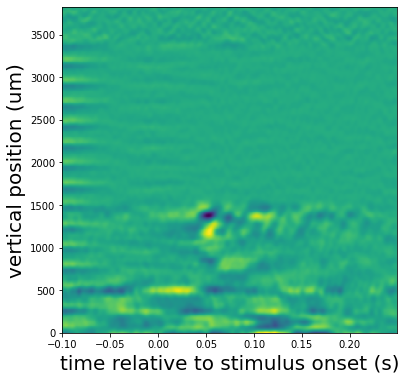

In [100]:
filtered_csd = gaussian_filter(csd.data, sigma=4)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pcolor(csd["time"], csd["vertical_position"], filtered_csd)

ax.set_xlabel("time relative to stimulus onset (s)", fontsize=20)
ax.set_ylabel("vertical position (um)", fontsize=20)

plt.show()

### Suggested exercises

If you would hands-on experience with the `EcephysSession` class, please consider working through some of these excercises.

- **tuning curves** : Pick a stimulus parameter, such as orientation on drifting gratings trials. Plot the mean and standard error of spike counts for each unit at each value of this parameter.
- **signal correlations** : Calculate unit-pairwise correlation coefficients on the tuning curves for a stimulus parameter of interest (`numpy.corrcoef` might be useful).
- **noise correlations** : Build for each unit a vector of spike counts across repeats of the same stimulus condition. Compute unit-unit correlation coefficients on these vectors.
- **cross-correlations** : Start with two spike trains. Call one of them "fixed" and the other "moving". Choose a set of time offsets and for each offset:
    1. apply the offset to the spike times in the moving train
    2. compute the correlation coefficient between the newly offset moving train and the fixed train.
    You should then be able to plot the obtained correlation coeffients as a function of the offset. 
- **unit clustering** : First, extract a set of unitwise features. You might draw these from the mean waveforms, for instance:
    - mean duration between waveform peak and trough (on the unit's peak channel)
    - the amplitude of the unit's trough
    
    or you might draw them from the unit's spike times, such as:
    - median inter-spike-interval
    
    or from metadata
    - CCF structure
    
    With your features in hand, attempt an unsupervised classification of the units. If this seems daunting, check out the [scikit-learn unsupervised learning documention](https://scikit-learn.org/stable/modules/clustering.html#clustering) for library code and examples.
- **population decoding** : Using an `EcephysSession` (and filtering to some stimuli and units of interest), build two aligned matrices:
    1. A matrix whose rows are stimulus presentations, columns are units, and values are spike counts.
    2. A matrix whose rows are stimulus presentations and whose columns are stimulus parameters.
    
    Using these matrices, train a classifier to predict stimulus conditions (sets of stimulus parameter values) from presentationwise population spike counts. See the [scikit-learn supervised learning tutorial](https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html) for a guide to supervised learning in Python.